# **Load**

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset from UCI repository or local CSV
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
cols = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
        'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

df = pd.read_csv(url, names=cols)


In [3]:
print(df.head())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


In [4]:
print(df.describe())

       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  

In [5]:
print(df['Outcome'].value_counts())

Outcome
0    500
1    268
Name: count, dtype: int64


# **EDA**

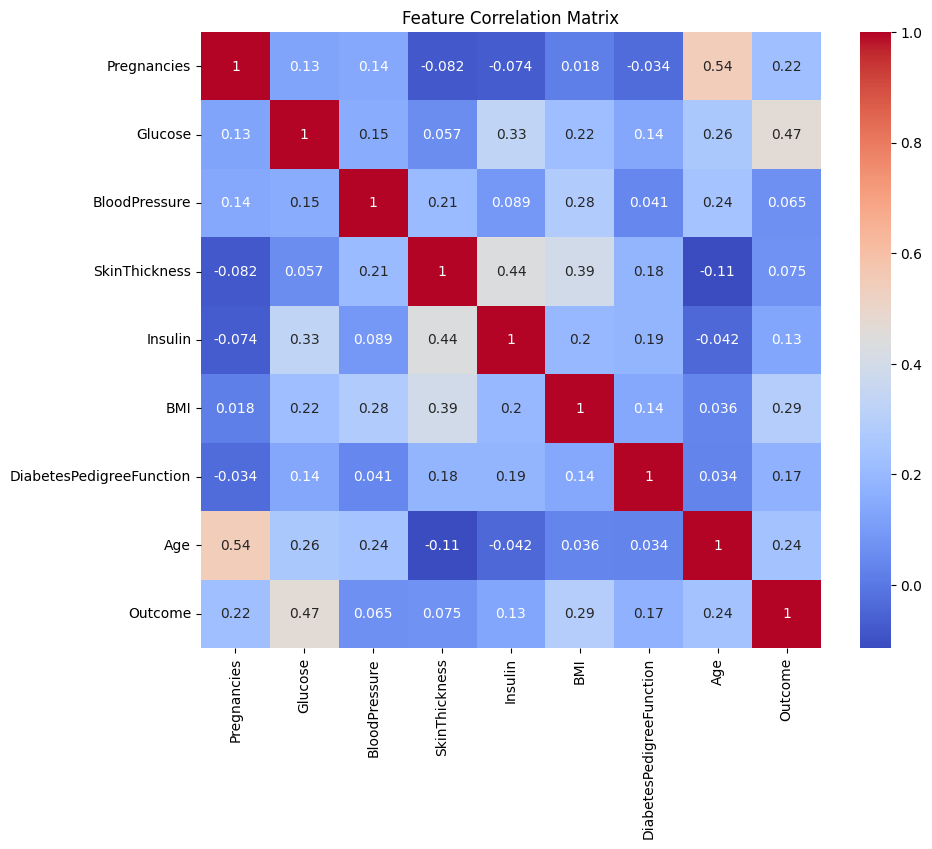

In [6]:
# Visualize correlations
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()


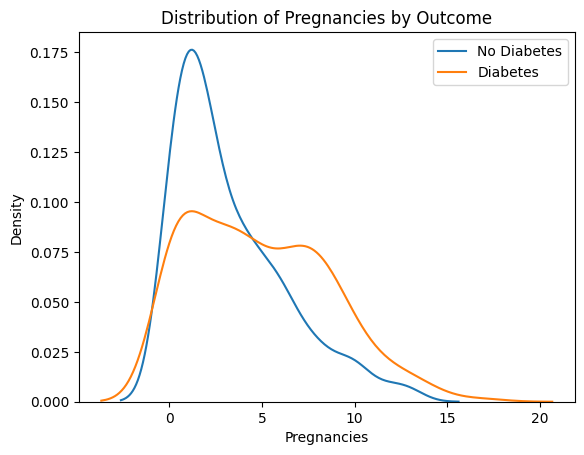

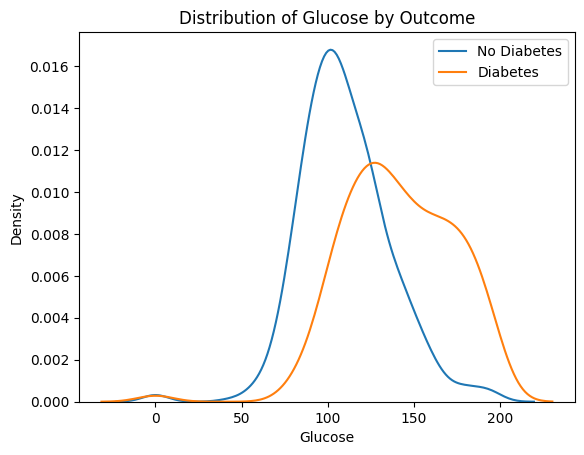

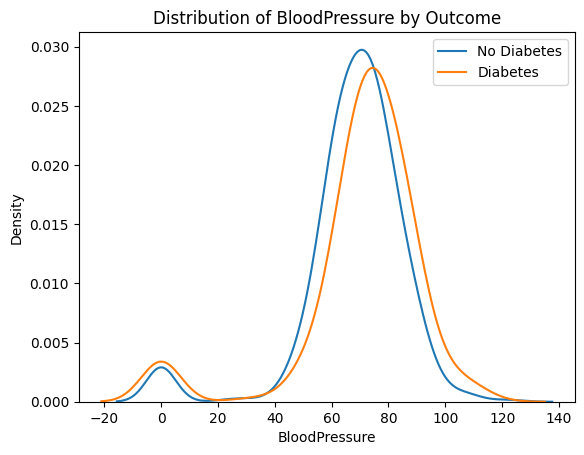

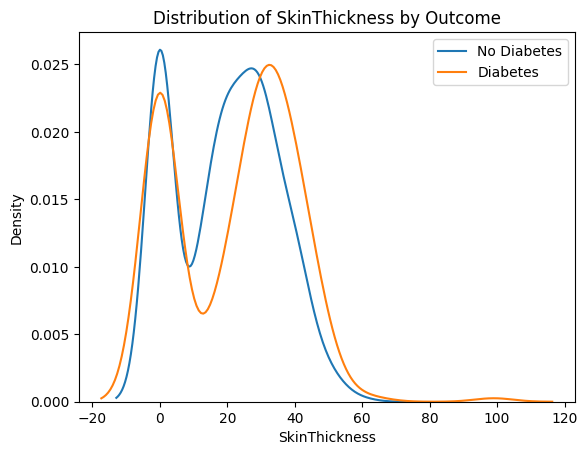

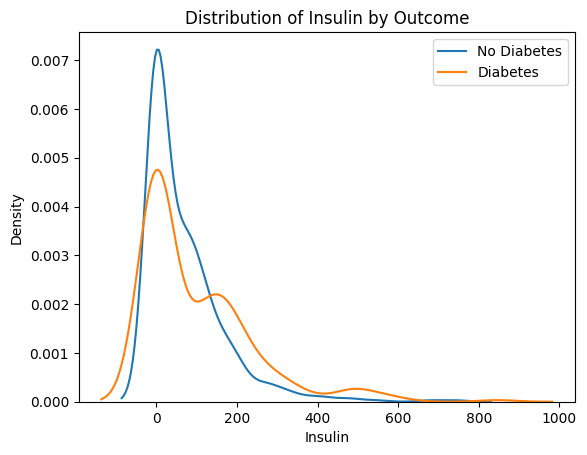

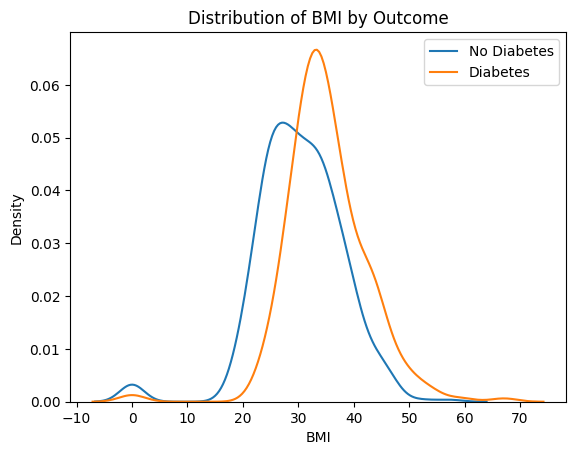

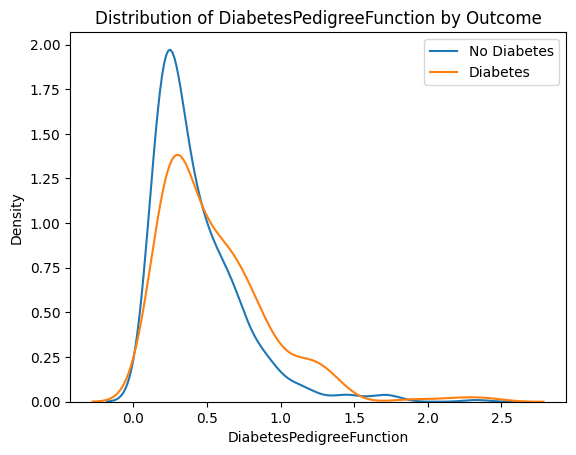

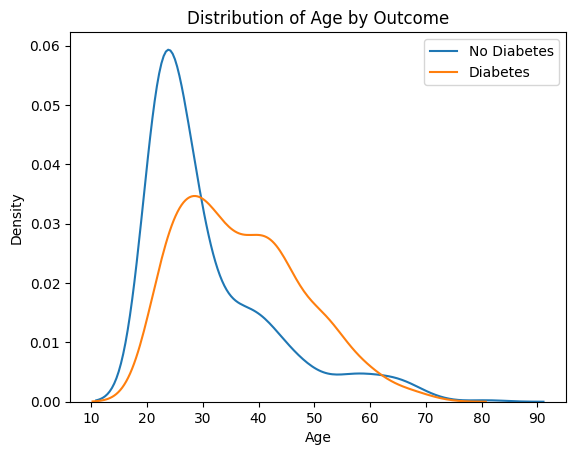

In [7]:
# Distribution of features by Outcome
for col in cols[:-1]:
    plt.figure()
    sns.kdeplot(df[df['Outcome'] == 0][col], label='No Diabetes')
    sns.kdeplot(df[df['Outcome'] == 1][col], label='Diabetes')
    plt.title(f'Distribution of {col} by Outcome')
    plt.legend()
    plt.show()


# **Feature selection **

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif

X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Feature selection (top 6 features)
selector = SelectKBest(score_func=f_classif, k=6)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]

print("Selected Features:", list(selected_features))



Selected Features: ['Pregnancies', 'Glucose', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


# **Scaling**

In [9]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


# **Train Models**

In [10]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score, roc_auc_score, RocCurveDisplay

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Gradient Boosting
gbm = GradientBoostingClassifier(random_state=42)
gbm.fit(X_train, y_train)

# SVM (with probability=True to get ROC curve)
svm = SVC(probability=True, random_state=42)
svm.fit(X_train, y_train)


SVC(probability=True, random_state=42)

In [11]:
# Convert data to tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

train_ds = TensorDataset(X_train_t, y_train_t)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)

class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleNN(X_train.shape[1]).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train for 20 epochs
model.train()
for epoch in range(20):
    total_loss = 0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {total_loss/len(train_dl):.4f}")


Epoch 1 Loss: 0.7137
Epoch 2 Loss: 0.6701
Epoch 3 Loss: 0.6326
Epoch 4 Loss: 0.5997
Epoch 5 Loss: 0.5583
Epoch 6 Loss: 0.5251
Epoch 7 Loss: 0.4945
Epoch 8 Loss: 0.4775
Epoch 9 Loss: 0.4728
Epoch 10 Loss: 0.4546
Epoch 11 Loss: 0.4524
Epoch 12 Loss: 0.4614
Epoch 13 Loss: 0.4769
Epoch 14 Loss: 0.4622
Epoch 15 Loss: 0.4407
Epoch 16 Loss: 0.4615
Epoch 17 Loss: 0.4357
Epoch 18 Loss: 0.4679
Epoch 19 Loss: 0.4380
Epoch 20 Loss: 0.4587


# ** Evaluate Models**

In [15]:
from sklearn.metrics import classification_report, f1_score, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
import torch




def evaluate_model(name, model, X_test, y_test):
    if name == "Neural Network":
        model.eval()
        with torch.no_grad():

            inputs = torch.tensor(X_test, dtype=torch.float32).to(device)
            preds = model(inputs).cpu().numpy()
        y_pred = (preds >= 0.5).astype(int)
        y_scores = preds.flatten()
    else:
        y_pred = model.predict(X_test)
        if hasattr(model, "predict_proba"):
            y_scores = model.predict_proba(X_test)[:,1]
        else:
            y_scores = model.decision_function(X_test)

    print(f"--- {name} ---")
    print(classification_report(y_test, y_pred))
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
    print(f"AUC-ROC: {roc_auc_score(y_test, y_scores):.4f}")

    # Plot ROC curve inside the function
    RocCurveDisplay.from_predictions(y_test, y_scores)
    plt.title(f"{name} ROC Curve")
    plt.show()



# **Gradient Boosting**

--- Gradient Boosting ---
              precision    recall  f1-score   support

           0       0.82      0.78      0.80        99
           1       0.63      0.69      0.66        55

    accuracy                           0.75       154
   macro avg       0.73      0.73      0.73       154
weighted avg       0.75      0.75      0.75       154

F1 Score: 0.6609
AUC-ROC: 0.8136


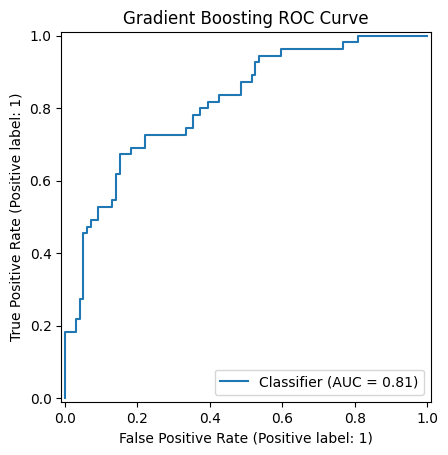

In [16]:
# Ensure gbm, svm, model, X_test, y_test, and device are defined in previous cells.
evaluate_model("Gradient Boosting", gbm, X_test, y_test)


# **SVM**

--- SVM ---
              precision    recall  f1-score   support

           0       0.79      0.85      0.82        99
           1       0.69      0.60      0.64        55

    accuracy                           0.76       154
   macro avg       0.74      0.72      0.73       154
weighted avg       0.75      0.76      0.76       154

F1 Score: 0.6408
AUC-ROC: 0.8248


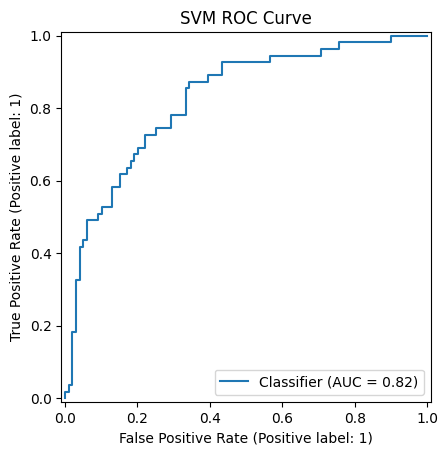

In [17]:
evaluate_model("SVM", svm, X_test, y_test)


# **Neural Network**

--- Neural Network ---
              precision    recall  f1-score   support

           0       0.80      0.81      0.80        99
           1       0.65      0.64      0.64        55

    accuracy                           0.75       154
   macro avg       0.72      0.72      0.72       154
weighted avg       0.75      0.75      0.75       154

F1 Score: 0.6422
AUC-ROC: 0.7993


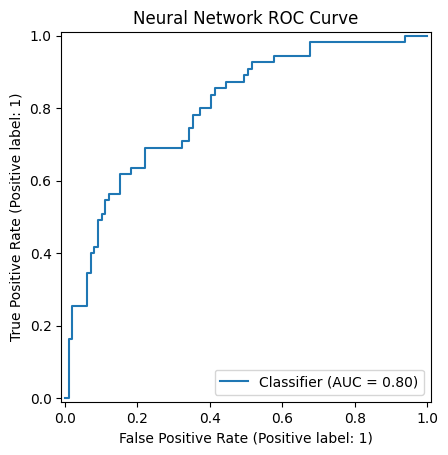

In [18]:
evaluate_model("Neural Network", model, X_test, y_test)

# **Insights for Healthcare Professionals**

In [19]:
import numpy as np


feat_importances = gbm.feature_importances_
for f, imp in zip(selected_features, feat_importances):
    print(f"{f}: {imp:.4f}")

print("\nInsights:")
print("- Glucose and BMI are among the most important predictors of diabetes.")
print("- Higher glucose and BMI values generally increase diabetes risk.")
print("- Early monitoring and lifestyle adjustments can help prevent progression.")




Pregnancies: 0.0312
Glucose: 0.4212
Insulin: 0.0766
BMI: 0.1970
DiabetesPedigreeFunction: 0.1070
Age: 0.1670

Insights:
- Glucose and BMI are among the most important predictors of diabetes.
- Higher glucose and BMI values generally increase diabetes risk.
- Early monitoring and lifestyle adjustments can help prevent progression.
